# Is normality a good assumption?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
from scipy.stats import norm, binom_test
import math

In [3]:
data = pd.read_csv(f'../UpdateOrderBook/bbo-2024-41.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)
data

,PktSeqNum,MsgSeqNum,MsgType,Symbol,BidPrice,BidQuantity,AskPrice,AskQuantity,TradingStatus
Time,,,,,,,,,
2024-10-06 10:03:58.595406,544,563,A,VXV4,16.00,50,0.0,0,Q
2024-10-06 10:03:58.595406,627,635,A,VXV4,16.55,1,0.0,0,Q
2024-10-06 10:03:58.595406,627,636,A,VXV4,16.55,2,0.0,0,Q
2024-10-06 10:03:58.595406,627,637,A,VXV4,16.60,1,0.0,0,Q
2024-10-06 10:03:58.595406,627,638,A,VXV4,16.60,2,0.0,0,Q
...,...,...,...,...,...,...,...,...,...
2024-10-11 16:00:01.575645,1491615,1491615,D,VXH5,11.80,2,0.0,0,S
2024-10-11 16:00:01.575645,1491618,1491618,D,VXMX4,0.00,0,0.0,0,S
2024-10-11 16:00:01.575645,1491618,1491619,D,VXMV4,0.00,0,0.0,0,S


In [4]:
df = (data[data['TradingStatus']=='T']
      .groupby(['Time','Symbol'])
      .last()
      [['BidPrice','BidQuantity','AskPrice','AskQuantity']]
      ).reset_index('Symbol')

df['TradeDate'] = np.where(
    df.index.time <= pd.to_datetime('16:00').time(), 
    df.index.date, 
    df.index.date + pd.Timedelta(days=1)
)

df['Theo'] = (df['BidPrice'] * df['AskQuantity'] + df['AskPrice'] * df['BidQuantity']) / (df['BidQuantity'] + df['AskQuantity'])

df

,Symbol,BidPrice,BidQuantity,AskPrice,AskQuantity,TradeDate,Theo
Time,,,,,,,
2024-10-06 17:00:00.000686,VXV4,20.30,221,20.35,35,2024-10-07,20.343164
2024-10-06 17:00:00.000686,VXX4,19.25,124,19.30,104,2024-10-07,19.277193
2024-10-06 17:00:00.055626,VXV4,20.30,217,20.35,35,2024-10-07,20.343056
2024-10-06 17:00:00.055644,VXV4,20.30,217,20.35,47,2024-10-07,20.341098
2024-10-06 17:00:00.055653,VXV4,20.30,197,20.35,47,2024-10-07,20.340369
...,...,...,...,...,...,...,...
2024-10-11 15:59:59.060798,VXMZ4,18.80,22,18.98,10,2024-10-11,18.923750
2024-10-11 15:59:59.063235,VXMZ4,18.80,22,19.05,20,2024-10-11,18.930952
2024-10-11 15:59:59.065735,VXMF5,19.05,21,19.28,10,2024-10-11,19.205806


In [37]:
symbol = 'VXV4'
df_sub = (
    df[df['Symbol']=='VXV4']
    .groupby('TradeDate')
    .resample('1T')
    .last()
    .fillna(method='ffill')
    .reset_index('TradeDate', drop=True)
)

df_sub

,Symbol,BidPrice,BidQuantity,AskPrice,AskQuantity,TradeDate,Theo
Time,,,,,,,
2024-10-06 17:00:00,VXV4,20.30,46.0,20.35,54.0,2024-10-07,20.323000
2024-10-06 17:01:00,VXV4,20.25,22.0,20.30,39.0,2024-10-07,20.268033
2024-10-06 17:02:00,VXV4,20.20,28.0,20.25,47.0,2024-10-07,20.218667
2024-10-06 17:03:00,VXV4,20.20,38.0,20.25,43.0,2024-10-07,20.223457
2024-10-06 17:04:00,VXV4,20.20,25.0,20.25,43.0,2024-10-07,20.218382
...,...,...,...,...,...,...,...
2024-10-11 15:55:00,VXV4,21.15,299.0,21.20,132.0,2024-10-11,21.184687
2024-10-11 15:56:00,VXV4,21.15,238.0,21.20,132.0,2024-10-11,21.182162
2024-10-11 15:57:00,VXV4,21.15,233.0,21.20,135.0,2024-10-11,21.181658


In [38]:
df_test = df_sub.copy()
df_test['Theo_shift'] = df_test.groupby('TradeDate')['Theo'].shift(1)
df_test['abs_return'] = df_test['Theo'] - df_test['Theo_shift']  # Absolute return
df_test['simple_return'] = df_test['abs_return'] / df_test['Theo'] # Simple return
df_test['log_return'] = np.log(df_test['Theo']) - np.log(df_test['Theo_shift']) # Log return
# df_test = df_test.dropna()
df_test

,Symbol,BidPrice,BidQuantity,AskPrice,AskQuantity,TradeDate,Theo,Theo_shift,abs_return,simple_return,log_return
Time,,,,,,,,,,,
2024-10-06 17:00:00,VXV4,20.30,46.0,20.35,54.0,2024-10-07,20.323000,NaN,NaN,NaN,NaN
2024-10-06 17:01:00,VXV4,20.25,22.0,20.30,39.0,2024-10-07,20.268033,20.323000,-0.054967,-0.002712,-0.002708
2024-10-06 17:02:00,VXV4,20.20,28.0,20.25,47.0,2024-10-07,20.218667,20.268033,-0.049366,-0.002442,-0.002439
2024-10-06 17:03:00,VXV4,20.20,38.0,20.25,43.0,2024-10-07,20.223457,20.218667,0.004790,0.000237,0.000237
2024-10-06 17:04:00,VXV4,20.20,25.0,20.25,43.0,2024-10-07,20.218382,20.223457,-0.005074,-0.000251,-0.000251
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-11 15:55:00,VXV4,21.15,299.0,21.20,132.0,2024-10-11,21.184687,21.185653,-0.000966,-0.000046,-0.000046
2024-10-11 15:56:00,VXV4,21.15,238.0,21.20,132.0,2024-10-11,21.182162,21.184687,-0.002525,-0.000119,-0.000119
2024-10-11 15:57:00,VXV4,21.15,233.0,21.20,135.0,2024-10-11,21.181658,21.182162,-0.000505,-0.000024,-0.000024


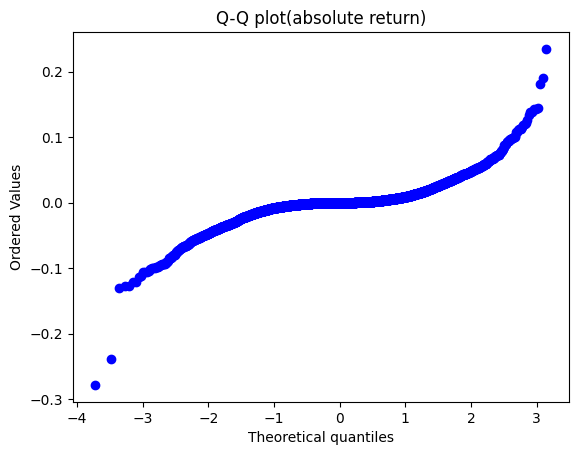

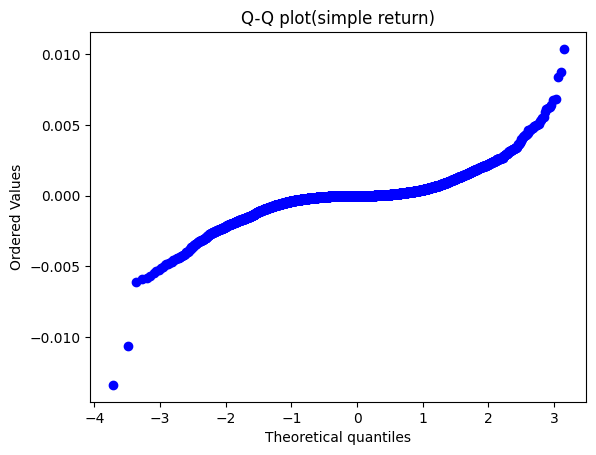

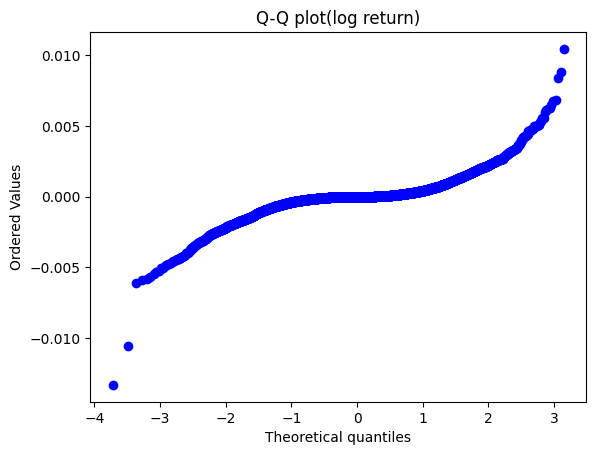

In [39]:
# Q-Q plot
stats.probplot(df_test['abs_return'], dist="norm", plot=plt)
plt.title('Q-Q plot(absolute return)')
plt.show()

stats.probplot(df_test['simple_return'], dist="norm", plot=plt)
plt.title('Q-Q plot(simple return)')
plt.show()

stats.probplot(df_test['log_return'], dist="norm", plot=plt)
plt.title('Q-Q plot(log return)')
plt.show()
